In [37]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from scipy import constants

# Exam Question 11-6:
In this question, we conduct an exact partition function calculation of the two lowest electric states of atomic iodine with it's fourfold degenerate ground electric state ($E=0 \text{ eV}$) and it's twofold degenerate first excited state ($E=0.9427 \text{ eV}$). We then also do a Monte Carlo simulation of this system to calculate the probability of being in the excited state. 

# Exact Partition Function Calculation
Below, we calculate the exact partition function. We do this by using the following formula provided in the book: $$q_{\text{elect}}(T)=g_{e1}+g_{e2}e^{\varepsilon_{e2}/k_BT}+\cdots$$ where we only care about the first two terms. We know that $g_{e1}=4,g_{e2}=2$, and to represent that degeneracy, we follow the hint provided and create a list with the electronic energies that we will randomly pull from. We then calculate the following probability for being in the first excited state:

$$f_{\text{excited}}=\frac{g_{e2}e^{\varepsilon_{e2}/k_BT}}{q_{\text{elect}}(T)}$$

The code we use to complete that task is the below cell. 

In [38]:
energy_list = np.array([0,0,0,0,0.9427,0.9427]) # creates an energy_list which includes degeneracy
energy_list = energy_list*1.6022e-19 # eV to Joules


"""
Function: energyElectric()
Inputs: N/A
Outputs: ground or excited (string)

Task: Given our list energy_list, randomly choose one of the entries in that list. If num==0, we are in the
ground state, otherwise we are in the excited state. 
"""
def energyElectric(): #  decides if we are in the excited or ground state.
    num = np.random.choice(energy_list,size=1)
    if num == 0:
       return "ground"
    if num == 0.9427*1.6022e-19:
       return "excited"

"""
Function: qExact(state,T)
Inputs: state (string), T (float)
Outputs: Q (float)

Task: Calculates the partition function for our system by summing all of the boltzman factors of our 
system. 
"""
def qExact(state,T): 
    """calculate the exact value of the partition function"""
    Q = 0 
    # Just have to sum the boltzman factors of the six states in our system. 
    for energy in energy_list:
        Q = Q + sy.exp(-energy/(constants.Boltzmann*T))
    return Q

""" 
Function: exactProbResult(state,T)
Inputs: state (string), T (float)

Task: Calculates the probability of being in the ground state or excited state given a particular Temperature 
"""
def exactProbResult(state,T):
    if state == 'ground':
        return sy.N(4*sy.exp(-energy_list[0]/(constants.Boltzmann*T))/qExact(state,T))
    elif state == 'excited':
        return sy.N(2*sy.exp(-energy_list[5]/(constants.Boltzmann*T))/qExact(state,T))

In [39]:
print("The exact probability of being in the excited state is {:.2%}".format(exactProbResult('excited',5000)))

The exact probability of being in the excited state is 5.31%


# Monte Carlo Functions

##### Collaborators: Aidan Cosgrove, Casey, Spencer (though we didn't explicitly work together) gave me the idea for my solution
Below, we define the various Monte Carlo (MC) functions required to perform a MC simulation for this electric simulation. These functions follow the same format as the vibrational frequency MC functions. Each functions purpose is described in the string statement above the prespective function. The main functions defined below are the following: calc_energy(), count(samples, entry), MCstep(state,T), runMC(initial_state, temperature, nEquil, num_steps), and MCProbResult(vSamples, vTarget).

In [40]:
"""
Function: calc_energy(state)
Inputs: state (string)
Outputs: state calculationg (float)

Task: Takes in the input 'ground' or 'excited' and returns the associated energy calculation for that energy level in J.
"""
def calc_energy(state):
   if state == "ground":
      return 0
   if state == "excited":
      return 0.9427*1.6022e-19 # Units in Joules
   

"""
Function: count(samples,entry)

Copied and kept entirely the same as the vibrational example. 
"""
def count(samples, entry):
  """making a python equivalent for the Mathematica "Count[]" function.
  "samples" should be your list of samples.
  "entry" should be which kind of entry you'd like to code to count for you.
  these are the same inputs that the Mathematica function would expect."""
  items, counts = np.unique(samples, axis=0, return_counts=True) # tally
  for i in range(len(items)):
    if np.array_equal(items[i],entry):
      return counts[i]

"""
Function: MCStep(state, T)
Inputs: state (string), T (float)

Task: Calculates deltaE between new_state - state, and if deltaE <= 0, then our system does not experience a desired change. 
However, if deltaE > 0, then we will take that change at the probability of the Boltzman distribution for that deltaE. If 
we do not accept the change, then we will return the original state. 
"""
def MCstep(state,T):
    new_state = energyElectric()
    deltaE = calc_energy(new_state) - calc_energy(state)
    if deltaE <= 0:
      return new_state
    else:
      randn = np.random.random()
      if randn < np.exp(-deltaE/(constants.Boltzmann*T)):
        return new_state
      else:
        return state

"""
What we are doing right now is finding the exact partial function. What we want to do with the Monte Carlo 
Simulation is see if we can have it be the same as the exact partial function. Our Monte Carlo simulation will follow
The following formatting:

Function: runMC(initial_state, temperature, nEquil, num_steps)
Inputs: initial_state(string), temperature(float), nEquil(integar), num_steps(integar)
Ouputs: states (list)

Task: Run the MCStep equal to num_steps, and then for every nEquil, we log that state. We then return a list of the states 
we collect from the Monte Carlo simulation. 
"""
def runMC(initial_state, temperature, nEquil, num_steps):
    """Run a Monte Carlo simulation."""
    states = [] # holds all the states
    current_state = initial_state # start either in ground or excited state

    for i in range(num_steps):
        current_state = MCstep(current_state, temperature) # change the state to the new state determined in MCStep
        if i%100 == 0:
            states.append(current_state)
    return states

"""
Function: MCProbResult(vSamples, vTarget)
Inputs: eSamples (list), eTarget(string)
Outputs: count(list, target)/len(eSamples)

Task: Calculates the probability of being either the ground state or the excited state based
on the MC simulation. 
"""
def MCProbResult(eSamples, eTarget):
    """
    Calculate the probability of an energy level given data from a
    Monte Carlo simulation.
    """
    if eTarget == 'ground':
       target = 0
    elif eTarget == 'excited':
       target = 1

    list = []

    """
    Interesting concept below, we only care about the two binaries of 'ground' and 'excited.' Thus, when we count up our list,
    we instead treat ground = 0 and excited = 1. We merely want to count how many we have in either the ground of excited state,
    and calculating that amount is easier when we associate with energy with a number after getting our list. 
    """
    for i in range(len(eSamples)): 
      if eSamples[i] == 'ground':
        list.append(0)
      elif eSamples[i] == 'excited':
        list.append(1)
    return count(list, target)/len(eSamples)


In [41]:
simlist = runMC(energyElectric(),5000,100,10000)
print("The probability of begin in the ground state at a temperature of 5000 is", MCProbResult(simlist, 'ground'))

The probability of begin in the ground state at a temperature of 5000 is 0.96


### Monte Carlo Convergence
Below, we do a convergence test for the Monte Carlo simulation to calculate the probability of being in the 'excited' state.

In [46]:
state = energyElectric() # Pick some random state, between Excited or Ground
temperature = 5000 # in K 
convergenceTest = [] #dont change this; re-initializes the list of outcomes
for nDataCol in np.arange(1000,100000,2000): #dont change this; this specifies how many simulations
    convergenceTest.append(MCProbResult(runMC(state,temperature,100,10000),'excited')) #put something in here to append to the list
# convergenceTest

### Monte Carlo Plot
Below, we plot the MC steps versus the exact calculation of the probability of begin in the excited. There seems to be a large amount of varience for our MC simulation, however, the graph is making the graph look deceiving. The varience is occuring within $\pm 0.02$ of the exact value. 

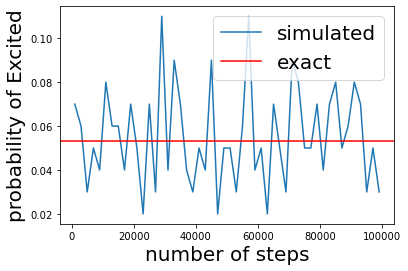

In [47]:
plt.plot(np.arange(1000,100000,2000),convergenceTest,label='simulated')
plt.axhline(exactProbResult('excited',5000), color='r', linestyle='-',label='exact') #plot a horizontal line at the exact value
plt.xlabel("number of steps",fontsize=20)
plt.ylabel("probability of Excited",fontsize=20)
plt.legend(fontsize=20)